In [1]:
import numpy as np
from training_data import generate_stationary_agent_choices
from collections import Counter
import pandas as pd

In [2]:
from load_data import load_common_metadata
from outguesser import linear_choice_history_dependent_model

In [3]:
from outguesser import separate_choices_sequences_into_history_and_choice

from outguesser import momentum_gradient_descent, maximum_a_posteriori

In [4]:
data_dir = '../experiments/'
metadata = load_common_metadata(data_dir)

In [5]:
metadata

,AgentName,ChoicesFile,ConfigFile,Date,DeviceType,GameIdx,GameVariant,ModelFile
0,alessandro,agent_choices_alessandro_0001.csv,config/experiment1.json,20180828_08:31:30,Desktop,1,no_feedback_v1,model_params_alessandro_0001.csv
1,alex,agent_choices_alex_0001.csv,config/experiment2.json,20180828_14:21:02,Mobile,1,no_feedback_v2,model_params_alex_0001.csv
2,chen,agent_choices_chen_0001.csv,config/experiment2.json,20180828_14:16:44,Desktop,1,no_feedback_v2,model_params_chen_0001.csv
3,brianlau,agent_choices_brianlau_0001.csv,config/experiment2.json,20180828_14:25:21,Mobile,1,no_feedback_v2,model_params_brianlau_0001.csv
4,bhanu,agent_choices_bhanu_0001.csv,config/experiment1.json,20180827_23:17:35,Desktop,1,no_feedback_v1,model_params_bhanu_0001.csv
5,andre,agent_choices_andre_0001.csv,config/experiment2.json,20180828_14:12:28,Desktop,1,no_feedback_v2,model_params_andre_0001.csv
6,bhanu,agent_choices_bhanu_0002.csv,config/experiment1.json,20180828_10:20:20,Mobile,2,no_feedback_v1,model_params_bhanu_0002.csv
7,laura,agent_choices_laura_0001.csv,config/experiment2.json,20180828_14:09:52,Mobile,1,no_feedback_v2,model_params_laura_0001.csv
8,lr,agent_choices_lr_0001.csv,config/experiment2.json,20180828_14:19:14,Desktop,1,no_feedback_v2,model_params_lr_0001.csv
9,amadeus,agent_choices_amadeus_0001.csv,config/experiment1.json,20180827_23:11:00,Desktop,1,no_feedback_v1,model_params_amadeus_0001.csv


In:
* agent, history length, cross validation

Out: 
* parameters, classification error

In [6]:
def get_model_params(expdataframe, weight_prior, optimizer):
    choices = pd.DataFrame.from_csv(data_dir + expdataframe['ChoicesFile']).values
    weights = optimizer(weight_prior, choices)
    return weights

# Bias and serial correlations

In [7]:
history_length = 10
weight_prior = np.zeros((history_length+1))


In [8]:
model_params=[]
for i in range(len(metadata)):
    model_params = model_params + [get_model_params(metadata.iloc[i], weight_prior, linear_choice_history_dependent_model)]
    

/home/amadeus/miniconda3/envs/unbias/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [9]:
mean_abs_weights = np.mean(np.abs(np.array(model_params)), axis=0)

### Plot

### Show biases

In [10]:
import matplotlib.pyplot as plt
from training_data import sigmoid

In [11]:
%matplotlib inline

* add probability of a 1 on the left figure

In [12]:
from training_data import sigmoid

### Classification error

In [13]:
from outguesser import regularized_momentum_gradient_descent
def get_classification_error(experiment, history_length):
    choices = pd.DataFrame.from_csv(data_dir + experiment['ChoicesFile']).values
    x, y = separate_choices_sequences_into_history_and_choice(choices[:,0], history_length)
    
    ones_row = np.ones((1, x.shape[1]))
    x = np.concatenate((ones_row, x), axis=0)

    number_of_data_points = x.shape[1]
    validation_chunk_size = int(validation_ratio*number_of_data_points)
    all_indxs = np.arange(0, number_of_data_points)
    weight_prior = np.zeros((history_length+1,))

    classification_error=[]
    for i in np.arange(0, int(number_of_data_points/validation_chunk_size)):
        test_idxs = np.arange(i*validation_chunk_size, (i+1)*validation_chunk_size)
        training_idxs = np.array(list(set(all_indxs)-set(test_idxs)))
        model_params = momentum_gradient_descent(weight_prior, x[:,training_idxs], y[training_idxs])
        predictions = [maximum_a_posteriori(model_params,x_i) for x_i in np.transpose(x[:, test_idxs])]
        classification_error.append(np.sum(predictions!=y[test_idxs])/validation_chunk_size)
    return classification_error
    

#### Cross validation

In [14]:
validation_ratio = 0.2
history_length = 4

In [15]:
classification_errors=[]
for i in range(len(metadata)):
    classification_errors.append(get_classification_error(metadata.iloc[i], history_length))
    

/home/amadeus/miniconda3/envs/unbias/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
mean_class_errors = np.mean(np.array(classification_errors), axis=1)

In [17]:
np.mean(mean_class_errors)

0.3795918367346938

/home/amadeus/miniconda3/envs/unbias/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


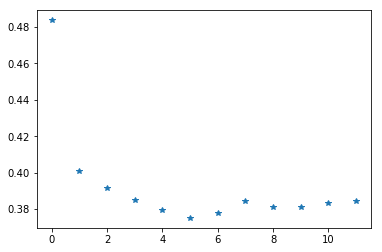

In [18]:
mean_error = np.zeros((12,))
for history_length in range(0,12):
    classification_errors=[]
    for i in range(len(metadata)):
        classification_errors.append(get_classification_error(metadata.iloc[i], history_length))
    mean_class_errors = np.mean(np.array(classification_errors), axis=1)
    mean_error[history_length] = np.mean(mean_class_errors)
plt.plot(mean_error,'*')
plt.show()

#### Ranking

In [19]:
results = list(zip(metadata['AgentName'].values, mean_class_errors))
results.sort(key=lambda x: x[1])
results

[('laura', 0.2680851063829787),
 ('amadeus', 0.2851063829787234),
 ('poornima', 0.2893617021276596),
 ('poornima', 0.2978723404255319),
 ('sara', 0.30638297872340425),
 ('vassilis', 0.3191489361702128),
 ('paulpfeiffer', 0.33191489361702126),
 ('paulpfeiffer', 0.3361702127659575),
 ('nikita', 0.3489361702127659),
 ('amadeus', 0.34893617021276596),
 ('sr', 0.34893617021276596),
 ('monzilur', 0.3574468085106383),
 ('alex', 0.3617021276595745),
 ('chen', 0.37021276595744684),
 ('brianlau', 0.3872340425531915),
 ('vincent', 0.44255319148936173),
 ('bhanu', 0.451063829787234),
 ('paulpfeiffer', 0.45106382978723414),
 ('lr', 0.4595744680851063),
 ('samuel', 0.45957446808510644),
 ('andre', 0.46382978723404256),
 ('ninjaturtle', 0.46382978723404256),
 ('ninjaturtle', 0.4680851063829786),
 ('alessandro', 0.4936170212765957),
 ('bhanu', 0.502127659574468)]

In [20]:
import seaborn as sns

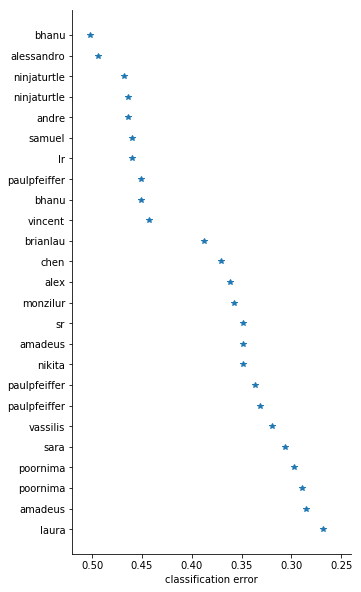

In [21]:

y = np.arange(0,len(metadata))
x = np.zeros((len(metadata),))
my_yticks = []
for i in range(len(metadata)):
    x[i] = results[i][1]
    my_yticks.append(results[i][0])
    
    
plt.figure(figsize=(5,10))

plt.yticks(y, my_yticks)
plt.plot(x, y,'*')
plt.xlabel('classification error')
plt.xlim(0.52,0.24)
sns.despine()
plt.savefig('../unbias',dpi=150,bbox_inches='tight')
plt.show()